In [14]:
import numpy as np
import cv2
import glob
from collections import namedtuple
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def calibrate_camera(images, grid_size=(9, 6)):
    """
    Calibrate camera parameters using images of 
    chesseboard

    :param images list : list of image path
    :param grid_size tuple: size of grid
    :param image_size tuple: size of image
    """
    if len(images) < 10:
        print('Not enough images for clibration!')
        return
    gw, gh = grid_size
    objp = np.zeros((gw*gh,3), np.float32)
    objp[:,:2] = np.mgrid[0:gw, 0:gh].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    img_size = (0,0)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (gw,gh), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx, dist, img_size, 1, img_size)
    return mtx, dist, newcameramtx, roi

def undistort_image(img, mtx, dist, newcameramtx=None, roi=None):
    """
    undistort image

    :param img image: image to be undistort
    :param mtx matrix: matrix for undisortion
    :param dist matrix : dist coeffients
    :param newcameramtx matrix: new camera matirx
    :param roi tuple: roi of valid pixels  
    """
    if (newcameramtx != None) and (roi != None):
        x,y,w,h = roi
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
        dst = dst[y:y+h, x:x+w]
    else:
        dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [16]:
def plot_imgs(im1, im2, titles=('IM1', 'IM2')):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(im1)
    ax1.set_title(titles[0], fontsize=50)
    ax2.imshow(im2)
    ax2.set_title(titles[1], fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [17]:
class Line:
    def __init__(self, x, y, y_max=719, line_coef=None, xm_per_pix= 3.7/700, ym_per_pix= 30/720, poly_order=2):
        self.x = x
        self.y = y
        self.ym_per_pix = ym_per_pix
        self.xm_per_pix = xm_per_pix
        self.poly_order = poly_order
        self._coef = line_coef
        self._coef_world = None
        self._curverad_world = None
        self._x_base = None
        self.y_max = y_max
    @property 
    def xy(self):
        return (self.x, self.y)
        
    @property
    def x_base(self):
        if self._x_base is None:
            self._x_base = self._get_x(self.y_max)
        return self._x_base
    @property
    def coef(self):
        if self._coef is None:
            self._coef = np.polyfit(self.y, self.x,  self.poly_order)
        return self._coef
    
    @property
    def coef_world(self):
        if self._coef_world is None:
            self._coef_world = self._convert_coef_pix2m(self.coef, self.xm_per_pix, self.ym_per_pix)
        return self._coef_world
    @property
    def curverad(self):
        if self._curverad_world is None:
            y_eval = self.y_max * self.ym_per_pix
            self._curverad_world = ((1 + (2*self.coef_world[0] * y_eval + self.coef_world[1])**2)**(3/2))/abs(2*self.coef_world[0])
        return self._curverad_world
    
    def _get_x(self, y):
        return self.coef[0] * y**2 + self.coef[1] * y + self.coef[2]
    
    def _convert_coef_pix2m(self, coef, xm_per_pix, ym_per_pix):
        a = coef[0] * xm_per_pix / (ym_per_pix**2)
        b = coef[0] * xm_per_pix / ym_per_pix
        return np.array([a, b, coef[2]])
             
# Define named tuple for Line pair        
line_pair = namedtuple('Line_pair', ['left', 'right'])


In [66]:
np.array([206, 598, 687, 1113])/1280

array([0.1609375 , 0.4671875 , 0.53671875, 0.86953125])

In [67]:

np.array([720, 455, 455, 720])/720

array([1.        , 0.63194444, 0.63194444, 1.        ])

In [68]:
class Lane_finder:
    
    def __init__(self, perspective_mtx=None, camera_mtx=None, dist=None, buffer_size=3):
        self.camera_mtx = camera_mtx
        self.dist = dist
        self.line_buffer = deque(maxlen=buffer_size)
        self.init = False
        self.curverad_diff_thresh = 500
        self.x_base_diff_thresh = 500
        self.min_curverad = 500
        #y_top = 0.62
        #x_low = 0.12
        #x_top_ctr = 0.034
        #self.points_x = np.array([x_low, 0.5-x_top_ctr, 0.5+x_top_ctr, 1-x_low]) 
        #self.points_y = np.array([1, y_top, y_top, 1])
        self.points_x = np.array([0.1609375 , 0.4671875 , 0.53671875, 0.86953125])
        self.points_y = np.array([1, 0.63194444, 0.63194444, 1])
        self.perspective_mtx = perspective_mtx
        self._inv_perspective_mtx = None
        
    
    @property
    def inv_perspective_mtx(self):
        if self._inv_perspective_mtx is None:
            self._inv_perspective_mtx = np.linalg.inv(self.perspective_mtx)
        return self._inv_perspective_mtx
        
    @property
    def last_line_pair(self):
        if len(self.line_buffer) == 0:
            return None
        return self.line_buffer[-1]
    
    def get_perspective_transform(self, size, offset=(300, 0)):
        offset_x, offset_y = offset
        w, h = size
        src_vertices = np.vstack((self.points_x*w, self.points_y*h)).transpose().astype(np.float32)
        dst_vertices = np.array([[offset_x, h], [offset_x, offset_y], [w-offset_x, offset_y], [w-offset_x, h]], dtype=np.float32)
        return cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    
    def check_valid(self, line_pair):
        if len(self.line_buffer) == 0:
            return True
        # check mininal of radius of curve
        if line_pair.left.curverad < self.min_curverad or line_pair.right.curverad < self.min_curverad:
            #print('curverad too small')
            return False
        # check diff of radius of curve
        left_curverad_invalid =  abs(line_pair.left.curverad - self.last_line_pair.left.curverad) > self.curverad_diff_thresh
        right_curverad_invalid =  abs(line_pair.right.curverad - self.last_line_pair.right.curverad) > self.curverad_diff_thresh
        #print('current_left curverad: {}, last left curverad: {}'.format(line_pair.left.curverad, self.last_line_pair.left.curverad))
        #print('current right curverad: {}, last right curverad: {}'.format(line_pair.right.curverad, self.last_line_pair.right.curverad))
        if left_curverad_invalid or right_curverad_invalid:
            #print('curverad diff too big')
            return False
        
        #print('left x_base')
        #print(abs(self.last_line_pair.left.x_base - line_pair.left.x_base))
        #print('right x_base')
        #print(abs(self.last_line_pair.right.x_base - line_pair.right.x_base))
        # check x base
        if abs(self.last_line_pair.left.x_base - line_pair.left.x_base) > self.x_base_diff_thresh \
            or abs(self.last_line_pair.right.x_base - line_pair.right.x_base) > self.x_base_diff_thresh:
            #print('x_base diff too big')
            return False
        return True
    
    def get_avg_line_pair(self, n=0):
        n_l = len(self.line_buffer)
        if n == 0 or n > n_l: 
            n = n_l
        left_coefs = []
        right_coefs = []
        for i in range(n_l-1, n_l-1-n, -1):
            left_coefs.append(self.line_buffer[i].left.coef)
            right_coefs.append(self.line_buffer[i].right.coef)
        mean_left_coef = np.array(left_coefs).mean(axis=0)
        mean_right_coef = np.array(right_coefs).mean(axis=0)
        # use last pixs for average line for efficiency
        left_line = Line(x=self.last_line_pair.left.x, y=self.last_line_pair.left.y, line_coef=mean_left_coef)
        right_line = Line(x=self.last_line_pair.right.x, y=self.last_line_pair.right.y, line_coef=mean_right_coef)
        return (left_line, right_line) 
            
        
    def process(self, img, vis='top'):
        undistorted_img = cv2.undistort(img, self.camera_mtx, self.dist, None, self.camera_mtx)
        h = undistorted_img.shape[0]
        w = undistorted_img.shape[1]
        filtered_im = self.filter_im(undistorted_img)
        if self.perspective_mtx is None:
            self.perspective_mtx = self.get_perspective_transform((w, h))
        warped_im = cv2.warpPerspective(filtered_im, 
                                        self.perspective_mtx, 
                                        (w, h), 
                                        cv2.INTER_LINEAR)
        if not self.init:
            left_pixs, right_pixs, xbase = self.find_pixels_window(warped_im)
            left_line = Line(left_pixs[0], left_pixs[1])
            right_line = Line(right_pixs[0], right_pixs[1])
            self.line_buffer.append(line_pair(left_line, right_line))
            self.init = True
        else:
            left_pixs, right_pixs = self.search_around_poly(warped_im, 
                                                       self.last_line_pair.left.coef, 
                                                       self.last_line_pair.right.coef, 
                                                       margin=100)
            left_line = Line(left_pixs[0], left_pixs[1])
            right_line = Line(right_pixs[0], right_pixs[1])
            if self.check_valid(line_pair(left_line, right_line)):
                self.line_buffer.append(line_pair(left_line, right_line))
            else: 
                self.init = False
        if vis == 'top':
            avg_line_left, avg_line_right = self.get_avg_line_pair()
            #return self.vis_poly(warped_im, avg_line_left, avg_line_right)
            return self.vis_poly(warped_im, self.last_line_pair.left, self.last_line_pair.right)
        elif vis == 'camera':
            avg_line_left, avg_line_right = self.get_avg_line_pair()
            
            result = self.vis_camera(undistorted_img, warped_im, avg_line_left, avg_line_right)
            avg_curverad = (avg_line_left.curverad + avg_line_right.curverad) / 2
            lane_car_diff = (avg_line_left.x_base + (avg_line_right.x_base  - avg_line_left.x_base) / 2 - w / 2) * avg_line_left.xm_per_pix
            lr_text = 'left' if lane_car_diff > 0 else 'right'
            text1 = 'Radius of Curveture: {:.2f}m'.format(avg_curverad)
            text2 = 'Vehicle is {:.2f}m {} of center'.format(abs(lane_car_diff), lr_text)
            result = cv2.putText(result, text1, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)       
            result = cv2.putText(result, text2, (50, 130), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)       
            return result
        else:
            return warped_im
        
    def filter_im(self, img, s_thresh=(128, 255), sx_thresh=(31, 180)):
        # Convert to HLS color space and separate the V channel
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        l_channel = hls[:,:,1]
        s_channel = hls[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        binary = np.zeros_like(scaled_sobel)
        sx_idx = (scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])
        binary[sx_idx] = 1

        # Threshold color channel
        s_idx = (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])
        binary[s_idx] = 1
        return binary
    
    def vis_poly(self, binary_warped, left_line, right_line, margin=100):
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        leftx, lefty = left_line.xy
        rightx, righty = right_line.xy
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        left_fit = left_line.coef
        right_fit = right_line.coef
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        
        #left_pts = np.hstack([left_fitx, ploty]).astype(np.int32).reshape(-1, 1, 2)
        left_pts  = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_pts  = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        print(left_pts.shape)
        out_img = cv2.polylines(out_img, np.int_([left_pts]), False, (255,255,0), 2) 
        out_img = cv2.polylines(out_img, np.int_([right_pts]), False, (255,255,0), 2) 
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        return result
    
    def vis_camera(self, original_img, warped_img, left_line, right_line):
       # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        left_fit = left_line.coef
        right_fit = right_line.coef
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.inv_perspective_mtx, (original_img.shape[1], original_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
        return result
        
    def find_pixels_window(self, binary_warped, x_base=None, nwindows=9, xmargin=100, minpix=20):
        if x_base is None:
            histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
            midpoint = int(histogram.shape[0]//2)
            leftx_base = np.argmax(histogram[:midpoint])
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        else:
            leftx_base, rightx_base = x_base
        window_height = int(binary_warped.shape[0]//nwindows)
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        leftx_current = leftx_base
        rightx_current = rightx_base
        left_lane_inds = []
        right_lane_inds = []
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - xmargin
            win_xleft_high = leftx_current + xmargin  # Update this
            win_xright_low = rightx_current - xmargin  # Update this
            win_xright_high = rightx_current + xmargin  # Update this

            y_idx = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
            good_left_inds = ((nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high) & y_idx).nonzero()[0]
            good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & y_idx).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            if len(good_left_inds) > minpix:
                leftx_current = nonzerox[good_left_inds].mean().astype(int)
            if len(good_right_inds) > minpix:
                rightx_current = nonzerox[good_right_inds].mean().astype(int)

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return (leftx, lefty), (rightx, righty), (leftx_base, rightx_base)
    
    def search_around_poly(self, binary_warped, left_fit, right_fit, margin=100):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        nonzero_x_curve_left = left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2]
        nonzero_x_curve_right = right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + right_fit[2]
        left_lane_inds = (nonzerox >= nonzero_x_curve_left - margin) & (nonzerox < nonzero_x_curve_left + margin)
        right_lane_inds = (nonzerox >= nonzero_x_curve_right - margin) & (nonzerox < nonzero_x_curve_right + margin)

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        return (leftx, lefty), (rightx, righty)

### Camera Calibration

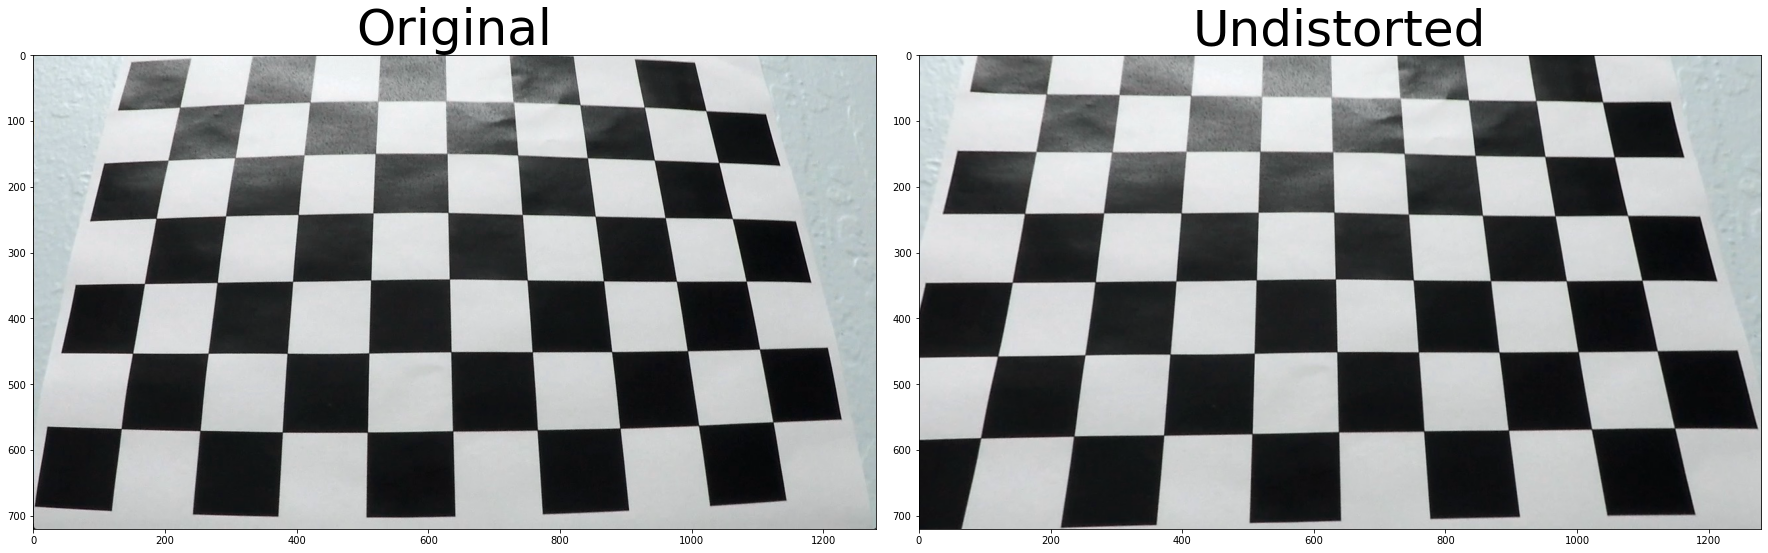

In [36]:
cali_path = 'camera_cal/*.jpg'
mtx, dist, newcameramtx, roi = calibrate_camera(glob.glob(cali_path))
test_img = cv2.imread(glob.glob(cali_path)[4])
undis_img = undistort_image(test_img, mtx, dist)
plot_imgs(test_img, undis_img, titles=('Original', 'Undistorted'))

### Process images

True

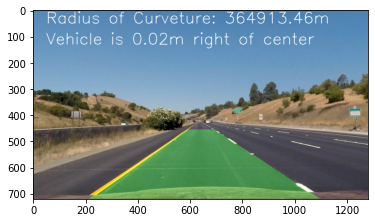

In [81]:
finder = Lane_finder(camera_mtx=mtx, dist=dist, buffer_size=3)
test_ims = glob.glob('test_images/*.jpg')

test_im = cv2.imread(test_ims[7])[:,:,::-1]
result = finder.process(test_im, 'camera')
plt.imshow(result)
cv2.imwrite('writeup_ims/final.png', result[:,:,::-1])

### Process videos

In [78]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

finder_video = Lane_finder(camera_mtx=mtx, dist=dist, buffer_size=3)
output_video = 'project_video_out.mp4'
#output_video = 'challenge_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(lambda im: finder_video.process(im, vis='camera')) #NOTE: this function expects color images!!
white_clip.write_videofile(output_video, audio=False)


t:   0%|          | 3/1260 [00:00<01:03, 19.80it/s, now=None]

Moviepy - Building video project_video_out.mp4.
Moviepy - Writing video project_video_out.mp4



Moviepy - Done !
Moviepy - video ready project_video_out.mp4


In [79]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [24]:
finder_video2 = Lane_finder(camera_mtx=mtx, dist=dist, buffer_size=3)
output_video = './challenge_video_out.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
#clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(lambda im: finder_video2.process(im, vis='camera')) #NOTE: this function expects color images!!
white_clip.write_videofile(output_video, audio=False)

t:   1%|          | 3/485 [00:00<00:22, 21.53it/s, now=None]

Moviepy - Building video ./challenge_video_out.mp4.
Moviepy - Writing video ./challenge_video_out.mp4



Moviepy - Done !
Moviepy - video ready ./challenge_video_out.mp4


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [27]:
finder_video3 = Lane_finder(camera_mtx=mtx, dist=dist, buffer_size=3)
output_video3 = './harder_challenge_video_out.mp4'
clip1 = VideoFileClip("./harder_challenge_video.mp4")
#clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(lambda im: finder_video3.process(im, vis='camera')) #NOTE: this function expects color images!!
white_clip.write_videofile(output_video3, audio=False)

t:   0%|          | 3/1199 [00:00<01:08, 17.35it/s, now=None]

Moviepy - Building video ./harder_challenge_video_out.mp4.
Moviepy - Writing video ./harder_challenge_video_out.mp4



t:  81%|████████  | 966/1199 [01:20<00:15, 14.63it/s, now=None]

ValueError: zero-size array to reduction operation maximum which has no identity

t:  81%|████████  | 966/1199 [01:33<00:15, 14.63it/s, now=None]